# Polynomial-Kernel SVM from Scratch on Breast Cancer Data
The Breast Cancer Wisconsin dataset has 30 real-valued features describing cell nuclei. A polynomial kernel lets an SVM separate classes using curved decision boundaries without explicitly mapping data into the high-dimensional feature space. Here we implement that mapping manually by expanding each feature vector into all degree-2 combinations (squares and pairwise products), then train a linear SVM with hinge-loss minimisation via stochastic sub-gradient descent. Finally we evaluate with a confusion matrix, precision/recall/F1, and an ROC curve to inspect the trade-off between true positives and false positives.

Shape of raw features: (569, 30)
Label distribution: (array([-1,  1]), array([357, 212]))
Shape after polynomial mapping: (569, 5456)
Training samples: 455
Testing samples : 114
Epoch 5/40 - Hinge Loss: 0.0485, Reg: 0.0005
Epoch 10/40 - Hinge Loss: 0.0308, Reg: 0.0006
Epoch 15/40 - Hinge Loss: 0.0195, Reg: 0.0006
Epoch 20/40 - Hinge Loss: 0.0148, Reg: 0.0006
Epoch 25/40 - Hinge Loss: 0.0160, Reg: 0.0007
Epoch 30/40 - Hinge Loss: 0.0129, Reg: 0.0007
Epoch 35/40 - Hinge Loss: 0.0113, Reg: 0.0007
Epoch 40/40 - Hinge Loss: 0.0101, Reg: 0.0008

Confusion Matrix:
 [[71  1]
 [ 3 39]]
Accuracy : 96.49%
Precision: 0.9750
Recall   : 0.9286
F1-Score : 0.9512
Epoch 35/40 - Hinge Loss: 0.0113, Reg: 0.0007
Epoch 40/40 - Hinge Loss: 0.0101, Reg: 0.0008

Confusion Matrix:
 [[71  1]
 [ 3 39]]
Accuracy : 96.49%
Precision: 0.9750
Recall   : 0.9286
F1-Score : 0.9512


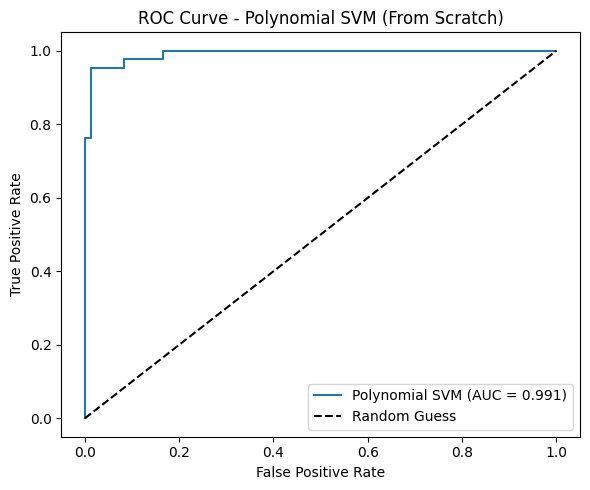

In [6]:
import numpy as np
import pandas as pd
from itertools import combinations_with_replacement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1️⃣ Load Dataset
# ------------------------------------------------------------------
file_path = "./datasets/breast_cancer_data.csv"
data = pd.read_csv(file_path)

# Drop identifier column if present
id_cols = [col for col in data.columns if col.lower() in {"id", "unnamed: 32"}]
if id_cols:
    data = data.drop(columns=id_cols)

# Map diagnosis column: M = malignant (1), B = benign (-1)
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": -1})

# Separate features and target
X_raw = data.drop(columns=["diagnosis"]).values.astype(float)
y = data["diagnosis"].values.astype(int)

print("Shape of raw features:", X_raw.shape)
print("Label distribution:", np.unique(y, return_counts=True))

# ------------------------------------------------------------------
# 2️⃣ Standardisation
# ------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# ------------------------------------------------------------------
# 3️⃣ Polynomial Feature Expansion (Equivalent to Polynomial Kernel)
# ------------------------------------------------------------------
def polynomial_feature_map(X, degree=3):
    """Explicitly map features to a polynomial feature space up to given degree."""
    n_samples, n_features = X.shape
    index_combos = []
    for d in range(degree + 1):
        index_combos.extend(combinations_with_replacement(range(n_features), d))

    Z = np.ones((n_samples, len(index_combos)))
    for col_idx, combo in enumerate(index_combos):
        if len(combo) == 0:
            continue  # already filled with ones for bias term
        Z[:, col_idx] = np.prod(X[:, combo], axis=1)
    return Z

X_poly = polynomial_feature_map(X_scaled, degree=3)
print("Shape after polynomial mapping:", X_poly.shape)

# ------------------------------------------------------------------
# 4️⃣ Train/Test Split
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])

# ------------------------------------------------------------------
# 5️⃣ Primal SVM (Hinge-Loss with Sub-Gradient Descent)
# ------------------------------------------------------------------
class PolynomialSVM:
    def __init__(self, learning_rate=0.0005, lambda_param=0.001, n_epochs=30):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_epochs = n_epochs
        self.w = None
        self.b = 0.0

    def fit(self, X, y):
        # Convert labels from {-1, 1}
        y_signed = y.astype(float)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0

        for epoch in range(self.n_epochs):
            for idx in range(n_samples):
                x_i = X[idx]
                condition = y_signed[idx] * (np.dot(x_i, self.w) + self.b)

                if condition >= 1:
                    # Only regularisation term contributes
                    grad_w = 2 * self.lambda_param * self.w
                    self.w -= self.lr * grad_w
                    # Bias has no update here
                else:
                    # Misclassified or inside margin
                    grad_w = 2 * self.lambda_param * self.w - y_signed[idx] * x_i
                    grad_b = -y_signed[idx]
                    self.w -= self.lr * grad_w
                    self.b -= self.lr * grad_b

            if (epoch + 1) % 5 == 0:
                margins = y_signed * (X @ self.w + self.b)
                hinge_loss = np.mean(np.maximum(0, 1 - margins))
                reg = self.lambda_param * np.dot(self.w, self.w)
                print(f"Epoch {epoch + 1}/{self.n_epochs} - Hinge Loss: {hinge_loss:.4f}, Reg: {reg:.4f}")

    def decision_function(self, X):
        return X @ self.w + self.b

    def predict(self, X):
        scores = self.decision_function(X)
        preds = np.where(scores >= 0, 1, -1)
        return preds

# ------------------------------------------------------------------
# 6️⃣ Train & Evaluate
# ------------------------------------------------------------------
svm = PolynomialSVM(learning_rate=0.0005, lambda_param=0.0005, n_epochs=40)
svm.fit(X_train, y_train)

y_scores = svm.decision_function(X_test)
y_pred = np.where(y_scores >= 0, 1, -1)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nConfusion Matrix:\n", cm)
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

# ------------------------------------------------------------------
# 7️⃣ ROC Curve
# ------------------------------------------------------------------
fpr, tpr, thresholds = roc_curve((y_test == 1).astype(int), y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Polynomial SVM (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Polynomial SVM (From Scratch)")
plt.legend()
plt.tight_layout()
plt.show()
